# kQ learn, Temperature split, CM features, minmax scaled

In [1]:
import pandas as pd
import surfreact.mlutils as mlut
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import joblib


from sklearn.gaussian_process.kernels import PairwiseKernel, Matern
import molml.molecule
import reaxnet.io.molml

## 1. Load data


In [2]:
MLdataset = mlut.load_MLdataset('../../../data/MLdataset/')

In [3]:
MLdataset = MLdataset.sort_values('reaction_id').reset_index(drop = True)

In [4]:
MLdataset

,reaction_number,reaction_id,metal_name,facetNum,equation,reactant_mass_gmol,reaction_energy,Temperature_list,Cff_status,kQ_Cff_unitstimeau,Cff_time_converged_au,reactant_geom,product_geom
0,1,4105,Rh,111,CH* + * -> C* + H*,13.019,0.016886,"[324, 356, 388]",True,"[8.439089996000001e-27, 8.528334979000001e-25,...","[8050, 8050, 8050]","(Atom('Rh', [0.0, 0.0, 9.999932], index=0), At...","(Atom('Rh', [0.0, 0.0, 9.999932], index=0), At..."
1,2,4119,Rh,111,COH* + * -> C* + OH*,29.018,0.024870,"[300.0, 308, 356, 381]",True,"[6.167286059e-25, 2.1418641489999997e-24, 1.17...","[8050, 8050, 8050, 8050]","(Atom('Rh', [-0.0, -0.0, 10.0], tag=9, index=0...","(Atom('Rh', [-0.0, -0.0, 10.0], tag=10, index=..."
2,3,4127,Rh,111,CHOH* + * -> CHO* + H*,30.026,-0.016445,"[300.0, 304, 355, 392]",True,"[4.7091193650000006e-26, 9.146473084e-26, 1.18...","[3955, 8015, 6195, 8015]","(Atom('Rh', [0.0, 0.0, 9.999932], index=0), At...","(Atom('Rh', [0.0, 0.0, 9.999932], index=0), At..."
3,4,4128,Rh,211,CH3* + * -> CH2* + H*,15.035,0.001734,"[150.0, 180, 277, 394]",True,"[8.655822108041674e-20, 3.1581820793463735e-17...","[8010, 8010, 8010, 8050]","(Atom('Rh', [2.733715, 2.232044, -6.313224], i...","(Atom('Rh', [2.733715, 2.232044, -6.313224], i..."
4,5,82687,Pt,111,CH2OH* + * -> CHOH* + H*,31.034,0.003384,"[300.0, 301, 359, 394]",True,"[2.9236971009999998e-24, 3.4104214149999996e-2...","[15040, 15040, 15040, 15040]","(Atom('Pt', [0.0, 0.0, 10.336705], index=0), A...","(Atom('Pt', [0.0, 0.0, 10.336705], index=0), A..."
5,6,82736,Ir,111,CH2* + * -> CH* + H*,14.027,-0.014666,"[150.0, 181, 310, 316]",True,"[6.175030253943774e-22, 6.196319745586352e-19,...","[8070, 8070, 8050, 8050]","(Atom('Ir', [0.0, 0.0, 10.077588], index=0), A...","(Atom('Ir', [0.0, 0.0, 10.077588], index=0), A..."
6,7,82754,Ir,111,CH3* + * -> CH2* + H*,15.035,0.011371,"[150.0, 212, 284, 326]",True,"[1.847925853248729e-25, 2.68103220697606e-19, ...","[6040, 8050, 8050, 8050]","(Atom('Ir', [0.0, 0.0, 10.077588], index=0), A...","(Atom('Ir', [0.0, 0.0, 10.077588], index=0), A..."
7,8,82755,Pt,111,CH3* + * -> CH2* + H*,15.035,0.016453,"[300.0, 326, 360, 382]",True,"[1.412256772e-22, 4.182732331e-21, 1.695614581...","[8050, 8050, 8050, 8050]","(Atom('Pt', [0.0, 0.0, 10.336705], index=0), A...","(Atom('Pt', [0.0, 0.0, 10.336705], index=0), A..."
8,9,82769,Ag,111,CHOH* + * -> HCO* + H*,30.026,0.003097,"[200.0, 241, 276, 340]",True,"[8.913179842086833e-21, 5.7568447277197286e-18...","[8050, 8050, 8050, 8050]","(Atom('Ag', [0.0, 0.0, 10.932598], index=0), A...","(Atom('Ag', [0.0, 0.0, 10.932598], index=0), A..."
9,10,82826,Ir,111,CHOH* + * -> CH* + OH*,30.026,-0.009481,"[200.0, 263, 278, 388]",True,"[1.1954511756806575e-24, 9.176101583765838e-20...","[5110, 8070, 8070, 8050]","(Atom('Ir', [0.0, 0.0, 10.077588], index=0), A...","(Atom('Ir', [0.0, 0.0, 10.077588], index=0), A..."


## 2. Compute features for atoms
Here we are selecting the 6 atoms that move the most during the reaction, then computing geometry features for them.

In [5]:
react_selected_list = []
prod_selected_list = []

for i, row in MLdataset.iterrows():
    
    print(row.reaction_id)
    
    react = row.reactant_geom
    prod = row.product_geom
    
    react_selected, prod_selected = mlut.get_moving_atoms(react, prod, 6)
    print(react_selected.get_chemical_symbols())
    react_selected_list.append(react_selected)
    prod_selected_list.append(prod_selected)

4105
[171 170 147 143 142 146]
['H', 'C', 'Rh', 'Rh', 'Rh', 'Rh']
4119
[36 38 37 28 30 31]
['H', 'O', 'C', 'Rh', 'Rh', 'Rh']
4127
[162 164 161 163 135 125]
['H', 'O', 'H', 'C', 'Rh', 'Rh']
4128
[99 98 96 97 81 84]
['H', 'H', 'C', 'H', 'Rh', 'Rh']
82687
[174 173 172 170 171 144]
['H', 'H', 'H', 'O', 'C', 'Pt']
82736
[171 170 172 148 150 149]
['H', 'C', 'H', 'Ir', 'Ir', 'Ir']
82754
[173 170 172 171 121 124]
['H', 'C', 'H', 'H', 'Ir', 'Ir']
82755
[173 170 172 171 121 122]
['H', 'C', 'H', 'H', 'Pt', 'Pt']
82769
[171 173 170 172 147 143]
['H', 'O', 'H', 'C', 'Ag', 'Ag']
82826
[171 173 172 170 148 150]
['H', 'O', 'C', 'H', 'Ir', 'Ir']
82843
[170 172 171 151 149 148]
['H', 'O', 'C', 'Pd', 'Pd', 'Pd']
432820
[30 27 29 28 25 22]
['H', 'C', 'H', 'O', 'Cu', 'Cu']
432827
[29 28 27 22 19 25]
['H', 'O', 'C', 'Cu', 'Cu', 'Cu']
432887
[29 28 27 19 18 25]
['H', 'H', 'C', 'Cu', 'Cu', 'Cu']


In [6]:
MLdataset['selected_reactant_atoms'] = react_selected_list
MLdataset['selected_product_atoms'] = prod_selected_list


#### Compute coulomb matrix features for selected atoms

In [7]:
reactants = []
products = []

for i, row in MLdataset.iterrows():
    reactants.append(row.selected_reactant_atoms)
    products.append(row.selected_product_atoms)
    

In [8]:
allgeoms = reactants + products

In [9]:
CM_input = [reaxnet.io.molml.atoms_to_molmllist(geom) for geom in allgeoms]

In [10]:
feat = molml.molecule.CoulombMatrix()

features = feat.fit_transform(CM_input)

In [11]:
reactant_feats = features[0:int(len(features)/2)]
product_feats = features[int(len(features)/2):]

CM_diff = [react - prod for prod, react in zip(product_feats, reactant_feats)]

In [12]:
geom_features = np.zeros((len(MLdataset), 36))

In [13]:
for i, feat in enumerate(CM_diff):
    geom_features[i,:] = feat

## 3. Combine features into one matrix

In [14]:
X, y  = mlut.concatenate_features_kQ(geom_features, MLdataset, log_cff=True)

## 4. Train/test split

In [15]:
X_train_indexed, X_test_indexed, y_train, y_test = mlut.temperature_split(X, y, MLdataset)

In [16]:
X_train = X_train_indexed[:, 1:]
X_test = X_test_indexed[:, 1:]

## 5. Scale CM values and other features


In [17]:
scaler = sklearn.preprocessing.MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## 6. Train a GPR

In [58]:
LS = 1
scale_min = 1e-5
scale_max = 1e5
Nr = 50
RS = 27
alpha = 1e-1

In [59]:
kernel = 1 * Matern(length_scale=LS, length_scale_bounds=(scale_min, scale_max)) + 1 * PairwiseKernel()

gpr = sklearn.gaussian_process.GaussianProcessRegressor(kernel = kernel, normalize_y = False, n_restarts_optimizer=Nr, random_state=RS, alpha = alpha)

gpr.fit(X_train, y_train)


/Users/bgpelkie/miniconda3/envs/cfflearning/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=0.1,
                         kernel=1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * PairwiseKernel(gamma=1.0, metric=linear),
                         n_restarts_optimizer=50, random_state=27)

## 7. Evalute model output

In [60]:
y_pred_train = gpr.predict(X_train)
train_MAE = sklearn.metrics.mean_absolute_error(y_train, y_pred_train)
MAPE_train = sklearn.metrics.mean_absolute_percentage_error(y_train, y_pred_train)*100
print(MAPE_train)
print(train_MAE)

0.08477430798349075
0.03679969534457961


In [61]:
train_MAE = sklearn.metrics.mean_absolute_error(y_train, y_pred_train)
print(train_MAE)

0.03679969534457961


In [62]:
y_pred, y_pred_std = gpr.predict(X_test, return_std=True)

In [63]:
MAE = sklearn.metrics.mean_absolute_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
MAPE = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)*100

print('MAE: ', MAE)
print('R2: ', r2)
print('MAPE (Table 2): ', MAPE)

MAE:  0.2700591360736616
R2:  0.9965573608647705
MAPE (Table 2):  0.6393228142559241


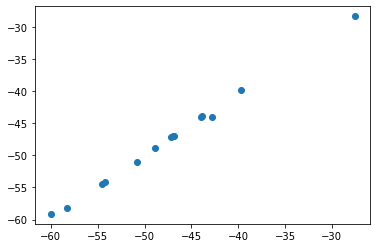

In [24]:
plt.scatter(y_test, y_pred)